# Data Augmentation Using the Full Feature Space and ML Evaluation

This notebook demonstrates the following steps:

1. **Data Augmentation**: Augment the full feature set (46 features) from the preprocessed dataset using:
   - SMOTE
   - ADASYN
   - CVAE (Conditional Variational Autoencoder)
   - GAN (Generative Adversarial Network)
   
   *Note*: For CVAE and GAN, only the minority class (target: "DDoS-SlowLoris") is augmented.

2. **Saving Augmented Data**: Save the augmented datasets to CSV files (with all 46 feature columns plus the original label).

3. **Dimensionality Reduction Comparison**: Load the saved CSV files and perform PCA and t‑SNE analyses (using all features as input) with the original multi‑class labels for coloring.

4. **Machine Learning Evaluation**: Convert the task to a binary problem (target vs. others) and evaluate several classifiers on:
   - The original data
   - Each augmented dataset (SMOTE, ADASYN, CVAE, and GAN)

5. **Summary and Visualization**: Combine the evaluation results from all models and generate summary plots:
   - A grouped bar chart comparing F1-Scores
   - ROC curves for each augmentation method

This comprehensive approach allows you to assess whether the synthetic samples match the real data distribution and how data augmentation impacts downstream classification performance.

In [5]:
# Cell 1: Import libraries and load the full dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the preprocessed dataset (46 features + 'label')
data = pd.read_csv("preprocessed_CICIoT2023.csv")
print("Dataset shape:", data.shape)

# Define the full list of columns (46 features + label)
full_columns = [
    "flow_duration",
    "Header_Length",
    "Protocol Type",
    "Duration",
    "Rate",
    "Srate",
    "Drate",
    "fin_flag_number",
    "syn_flag_number",
    "rst_flag_number",
    "psh_flag_number",
    "ack_flag_number",
    "ece_flag_number",
    "cwr_flag_number",
    "ack_count",
    "syn_count",
    "fin_count",
    "urg_count",
    "rst_count",
    "HTTP",
    "HTTPS",
    "DNS",
    "Telnet",
    "SMTP",
    "SSH",
    "IRC",
    "TCP",
    "UDP",
    "DHCP",
    "ARP",
    "ICMP",
    "IPv",
    "LLC",
    "Tot sum",
    "Min",
    "Max",
    "AVG",
    "Std",
    "Tot size",
    "IAT",
    "Number",
    "Magnitue",
    "Radius",
    "Covariance",
    "Variance",
    "Weight",
    "label"
]

# The feature columns are the first 46 elements
feature_columns = full_columns[:-1]

# Create a DataFrame with only feature columns
df = data[feature_columns].copy()
print("Using feature columns:", feature_columns)

# Define the target minority class for augmentation
target_label = "DDoS-SlowLoris"
print("Target minority class:", target_label)


Dataset shape: (2366956, 47)
Using feature columns: ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
Target minority class: DDoS-SlowLoris


In [6]:
# Cell 2: Preprocess the data: Standardize features and split into train/test
scaler = StandardScaler()
X = scaler.fit_transform(df[feature_columns])

# Pull the labels from the original DataFrame, not from df
y = data["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:",    X_test.shape)

Training set shape: (1656869, 46)
Test set shape: (710087, 46)


In [7]:
# Cell 3: Augmentation using SMOTE and ADASYN on the full feature set
from imblearn.over_sampling import SMOTE, ADASYN

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE, class distribution:")
print(pd.Series(y_train_smote).value_counts())

adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
print("After ADASYN, class distribution:")
print(pd.Series(y_train_adasyn).value_counts())
# Compute number of synthetic samples added by SMOTE
n_synthetic_smote = X_train_smote.shape[0] - X_train.shape[0]
print("Number of samples added by SMOTE:", n_synthetic_smote)

# Ensure CVAE and GAN generate the same number of synthetic samples


After SMOTE, class distribution:
DDoS-UDP_Flood             255190
DDoS-HTTP_Flood            255190
Mirai-udpplain             255190
CommandInjection           255190
DoS-HTTP_Flood             255190
Recon-PortScan             255190
Recon-HostDiscovery        255190
DDoS-SlowLoris             255190
Backdoor_Malware           255190
DDoS-TCP_Flood             255190
VulnerabilityScan          255190
BrowserHijacking           255190
Recon-PingSweep            255190
SqlInjection               255190
DictionaryBruteForce       255190
XSS                        255190
Recon-OSScan               255190
DNS_Spoofing               255190
MITM-ArpSpoofing           255190
DDoS-UDP_Fragmentation     255190
DoS-SYN_Flood              255190
BenignTraffic              255190
DDoS-ICMP_Fragmentation    255190
DDoS-ACK_Fragmentation     255190
Mirai-greeth_flood         255190
DDoS-PSHACK_Flood          255190
DDoS-RSTFINFlood           255190
Mirai-greip_flood          255190
DDoS-ICMP_Flood

In [8]:
# Cell 4: Augmentation using CVAE on the full feature set for the minority class
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Select minority class samples from X_train
minority_idx = np.where(y_train == target_label)[0]
X_minority = X_train[minority_idx]
print("Minority training set shape for target class (CVAE):", X_minority.shape)

input_dim = X_minority.shape[1]  # should be 46
latent_dim = 8

# Build the encoder
inputs = Input(shape=(input_dim,))
h = layers.Dense(64, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Build the decoder
decoder_h = layers.Dense(64, activation='relu')
decoder_mean = layers.Dense(input_dim, activation='linear')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Build and compile the CVAE model
cvae = Model(inputs, x_decoded_mean)
reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(inputs, x_decoded_mean)) * input_dim
kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
cvae_loss = reconstruction_loss + kl_loss
cvae.add_loss(cvae_loss)
cvae.compile(optimizer=Adam(learning_rate=0.001))

cvae.fit(X_minority, epochs=50, batch_size=32, verbose=1)

# Generate synthetic samples using CVAE
n_synthetic_cvae = n_synthetic_smote  # number of synthetic samples
z_sample = np.random.normal(size=(n_synthetic_cvae, latent_dim))

# Build a standalone decoder model for CVAE
decoder_input = Input(shape=(latent_dim,))
h_decoded_gen = decoder_h(decoder_input)
x_decoded_gen = decoder_mean(h_decoded_gen)
decoder_model = Model(decoder_input, x_decoded_gen)

X_synthetic_cvae = decoder_model.predict(z_sample)
print("Synthetic CVAE samples shape:", X_synthetic_cvae.shape)

# Combine the synthetic CVAE samples with the original training data
X_CVAE = np.concatenate([X_train, X_synthetic_cvae])
y_CVAE = np.concatenate([y_train, np.full(len(X_synthetic_cvae), target_label)])

Minority training set shape for target class (CVAE): (823, 46)
Epoch 1/50


2025-04-19 23:39:11.929259: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


26/26 [==============================] - 0s 543us/step - loss: 67.5300
Epoch 2/50
26/26 [==============================] - 0s 480us/step - loss: 43.8920
Epoch 3/50
26/26 [==============================] - 0s 386us/step - loss: 27.3543
Epoch 4/50
26/26 [==============================] - 0s 460us/step - loss: 19.6549
Epoch 5/50
26/26 [==============================] - 0s 541us/step - loss: 15.9886
Epoch 6/50
26/26 [==============================] - 0s 514us/step - loss: 13.9712
Epoch 7/50
26/26 [==============================] - 0s 490us/step - loss: 12.6578
Epoch 8/50
26/26 [==============================] - 0s 2ms/step - loss: 11.6595
Epoch 9/50
26/26 [==============================] - 0s 766us/step - loss: 10.7224
Epoch 10/50
26/26 [==============================] - 0s 426us/step - loss: 9.9569
Epoch 11/50
26/26 [==============================] - 0s 496us/step - loss: 9.1984
Epoch 12/50
26/26 [==============================] - 0s 507us/step - loss: 8.5893
Epoch 13/50
26/26 [==========

In [9]:
# Cell 5: Augmentation using GAN on the full feature set for the minority class
from tensorflow.keras.layers import LeakyReLU

noise_dim = 16

def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, input_dim=noise_dim, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(input_dim, activation='linear'))
    return model

def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# Build the GAN model
discriminator.trainable = False
gan_input = Input(shape=(noise_dim,))
generated_sample = generator(gan_input)
gan_output = discriminator(generated_sample)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

epochs = 1000
batch_size = 32
half_batch = batch_size // 2

# Use minority training samples for GAN training (from the same minority indices as before)
X_minority_train = X_train[minority_idx]
print("Minority training set shape for GAN:", X_minority_train.shape)

for epoch in range(epochs):
    idx = np.random.randint(0, X_minority_train.shape[0], half_batch)
    real_samples = X_minority_train[idx]
    noise = np.random.normal(0, 1, (half_batch, noise_dim))
    fake_samples = generator.predict(noise)
    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((half_batch, 1)))
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
    
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Discriminator loss = {d_loss:.4f}, Generator loss = {g_loss:.4f}")

n_synthetic_gan = n_synthetic_smote
noise = np.random.normal(0, 1, (n_synthetic_gan, noise_dim))
X_synthetic_gan = generator.predict(noise)
print("Synthetic GAN samples shape:", X_synthetic_gan.shape)

X_GAN = np.concatenate([X_train, X_synthetic_gan])
y_GAN = np.concatenate([y_train, np.full(len(X_synthetic_gan), target_label)])

Minority training set shape for GAN: (823, 46)
1/1 [==============================] - 0s 25ms/step


2025-04-19 23:40:33.868801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:33.996527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:33.999485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

Epoch 0: Discriminator loss = 0.8250, Generator loss = 0.8111
1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:34.187651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:34.190324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:34.192476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:34.393058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:34.395203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:34.397172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:34.594016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:34.596485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:34.598535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:34.805256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:34.807428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:34.809287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:35.005700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:35.008455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:35.010481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:35.214190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:35.216243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:35.218194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:35.421916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:35.424197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:35.426439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:35.633965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:35.636700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:35.638928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:35.841839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:35.844123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:35.846331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:36.047826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:36.049999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:36.052006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:36.252519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:36.254788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:36.256870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:36.460577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:36.462862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:36.465063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:36.664738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:36.666982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:36.668963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:36.875033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:36.877413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:36.879688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:37.084127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:37.086419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:37.088955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:37.290479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:37.292832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:37.295027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:37.496675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:37.498892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:37.500981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:37.724566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:37.732791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:37.735580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:37.936514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:37.938850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:37.940906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:38.144992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:38.168925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:38.172147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:38.356582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:38.358811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:38.360835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:38.560810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:38.563059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:38.565116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:38.773125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:38.775527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:38.777729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:38.980972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:38.983310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:38.985560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:39.191392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:39.193714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:39.195862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:39.401590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:39.404152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:39.406260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step
Epoch 200: Discriminator loss = 0.4301, Generator loss = 0.9582
1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:39.612712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:39.615099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:39.617223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:39.820313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:39.822711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:39.824975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:40.023103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:40.026174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:40.053580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:40.236461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:40.238850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:40.241035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:40.442507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:40.445753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:40.473409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:40.654604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:40.656885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:40.658904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:40.890942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:40.893289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:40.895638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:41.098354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:41.100589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:41.102893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:41.309644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:41.314658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:41.316852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:41.521486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:41.523914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:41.525981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:41.728870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:41.731114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:41.733323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:41.939347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:41.941683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:41.943758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:42.147521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:42.149803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:42.151947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:42.357020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:42.359424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:42.361713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:42.561775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:42.564171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:42.566338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:42.763567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:42.765974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:42.768156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:42.977564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:42.979932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:42.982033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:43.413008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:43.415223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:43.417289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:43.619565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:43.621837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:43.623965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:43.831227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:43.833712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:43.835937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:44.054546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:44.057090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:44.059462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:44.266584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:44.268930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:44.271319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:44.476099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:44.478402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:44.480556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:44.686735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:44.689167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:44.691434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:44.893110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:44.895320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:44.897523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:45.101379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:45.103790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:45.106085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step
Epoch 400: Discriminator loss = 0.4105, Generator loss = 1.0401
1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:45.305877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:45.308160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:45.310354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:45.516546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:45.518923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:45.521221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:45.719168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:45.721443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:45.723593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:45.930572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:45.932981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:45.935225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 12ms/step


2025-04-19 23:40:46.133973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:46.136357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:46.138457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:46.380980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:46.407794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:46.411992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:46.596606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:46.598895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:46.601155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:46.813521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:46.816177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:46.818300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:47.016136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:47.018323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:47.020506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:47.225540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:47.227822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:47.230007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:47.429718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:47.431995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:47.434090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:47.637130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:47.639433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:47.641709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:47.842649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:47.844880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:47.847025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:48.053475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:48.055847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:48.057959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:48.259373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:48.261714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:48.263769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 10ms/step


2025-04-19 23:40:48.469188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:48.471569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:48.473771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:48.678745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:48.680841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:48.705966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:48.892668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:48.895071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:48.897288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:49.096888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:49.099159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:49.101281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:49.309362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:49.311734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:49.313925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:49.522808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:49.547492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:49.550899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:49.730012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:49.732503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:49.734559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:49.939297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:49.941555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:49.943869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:50.151409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:50.154041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:50.156214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:50.355641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:50.357956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:50.360114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:50.563088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:50.565371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:50.567606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:50.773963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:50.776496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:50.778816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step
Epoch 600: Discriminator loss = 0.4243, Generator loss = 0.9783
1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:50.978868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:50.981097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:50.983214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:51.192145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:51.194646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:51.196917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:51.400157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:51.402426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:51.404765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:51.608817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:51.611059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:51.613343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 13ms/step


2025-04-19 23:40:51.816113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:51.818416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:51.820661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 10ms/step


2025-04-19 23:40:52.019050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:52.022056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:52.024303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:52.244152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:52.246507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:52.249063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:52.444894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:52.447300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:52.449395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:52.651222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:52.653648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:52.655881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:52.855584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:52.857848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:52.860082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:53.071990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:53.074562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:53.076782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:53.278875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:53.281213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:53.283348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:53.488123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:53.490472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:53.492816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:53.724403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:53.726797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:53.728989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 14ms/step


2025-04-19 23:40:53.930580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:53.932945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:53.935047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:54.139227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:54.141459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:54.143774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:54.346921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:54.349182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:54.351253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:54.554987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:54.557409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:54.559672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:54.757745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:54.759812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:54.784100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:54.966718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:54.969056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:54.971595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:55.174364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:55.176550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:55.178616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:55.377970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:55.385893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:55.412206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:55.590698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:55.593106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:55.595204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:55.799501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:55.801853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:55.804337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:56.005900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:56.008186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:56.010384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:56.213225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:56.215452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:56.217512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:56.422333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:56.424535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:56.437661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step
Epoch 800: Discriminator loss = 0.5040, Generator loss = 1.2538
1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:56.633753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:56.636142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:56.638552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:56.837218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:56.839532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:56.841653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:57.051077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:57.053601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:57.055822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:57.257539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:57.259856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:57.261933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:57.465216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:57.467496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:57.469763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:57.671762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:57.674071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:57.676199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:57.885010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:57.887699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:57.889890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:58.088471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:58.090777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:58.092984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:58.299500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:58.301888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:58.304064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:58.505537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:58.507852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:58.509956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:58.712209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:58.714486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:58.716672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:58.917657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:58.920058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:58.922405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:59.127320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:59.129625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:59.131851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:40:59.328234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:59.330791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:59.332950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:59.538394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:59.540738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:59.542929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:59.742394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:59.744577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:59.746642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:40:59.947434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:59.949748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:40:59.951887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:41:00.152318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:00.154526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:00.156613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:41:00.361553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:00.363776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:00.365962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:41:00.566180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:00.568469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:00.570785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:41:00.772291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:00.774532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:00.776623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:41:00.978523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:00.980820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:00.982927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:41:01.187136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:01.189452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:01.191791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:41:01.434924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:01.437486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:01.439727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:41:01.641458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:01.643644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:01.645686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:41:01.848769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:01.851063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:01.853304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 8ms/step


2025-04-19 23:41:02.053659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:02.055887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:02.057978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

1/1 [==============================] - 0s 9ms/step


2025-04-19 23:41:02.262794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:02.265028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [16,1]
	 [[{{node Placeholder/_1}}]]
2025-04-19 23:41:02.267245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,1]
	

219363/219363 [==============================] - 43s 197us/step
Synthetic GAN samples shape: (7019591, 46)


In [10]:
# Cell 6: Save the augmented datasets to CSV files using the full feature set

df_smote = pd.DataFrame(X_train_smote, columns=feature_columns)
df_smote["label"] = y_train_smote

df_adasyn = pd.DataFrame(X_train_adasyn, columns=feature_columns)
df_adasyn["label"] = y_train_adasyn

df_cvae = pd.DataFrame(X_CVAE, columns=feature_columns)
df_cvae["label"] = y_CVAE

df_gan = pd.DataFrame(X_GAN, columns=feature_columns)
df_gan["label"] = y_GAN

df_smote.to_csv("augmented_data_smote_full.csv", index=False)
df_adasyn.to_csv("augmented_data_adasyn_full.csv", index=False)
df_cvae.to_csv("augmented_data_cvae_full.csv", index=False)
df_gan.to_csv("augmented_data_gan_full.csv", index=False)

print("Augmented datasets have been saved to CSV files with the full feature set preserved.")

Augmented datasets have been saved to CSV files with the full feature set preserved.


## PCA Analysis on Augmented CSV Data

This section reads the saved CSV files and applies PCA on the full feature set (46 features),
using the original multi-class labels for coloring the 2D PCA results.


PCA Analysis for SMOTE augmented data
Explained Variance Ratio: [0.39197025 0.25082297]
PCA Loadings (transposed):
                      PC1       PC2
flow_duration    0.001128  0.002515
Header_Length   -0.003318 -0.003700
Protocol Type   -0.005187 -0.003305
Duration        -0.022064 -0.004699
Rate            -0.000278 -0.000364
Srate           -0.000278 -0.000364
Drate           -0.000003 -0.000003
fin_flag_number -0.000577 -0.000561
syn_flag_number -0.001496 -0.001848
rst_flag_number -0.000953 -0.001151
psh_flag_number -0.001084  0.007211
ack_flag_number -0.007398  0.013183
ece_flag_number -0.000021 -0.000019
cwr_flag_number -0.000009 -0.000010
ack_count       -0.000632  0.000235
syn_count       -0.004202  0.011554
fin_count       -0.001839 -0.001705
urg_count       -0.002888 -0.001671
rst_count       -0.003268 -0.002852
HTTP            -0.002624 -0.002878
HTTPS           -0.004955 -0.005134
DNS             -0.000931 -0.001156
Telnet          -0.000000 -0.000000
SMTP            -0.0

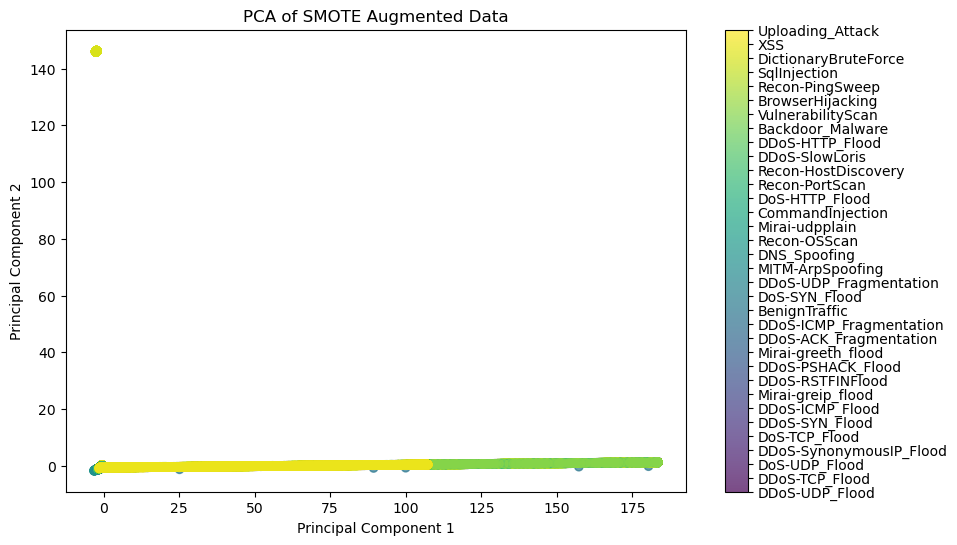


PCA Analysis for ADASYN augmented data
Explained Variance Ratio: [0.58613663 0.09192599]
PCA Loadings (transposed):
                      PC1       PC2
flow_duration    0.000519 -0.070492
Header_Length   -0.001931  0.019748
Protocol Type   -0.004624 -0.007067
Duration        -0.023242  0.035792
Rate            -0.000452 -0.001594
Srate           -0.000452 -0.001594
Drate           -0.000002 -0.000014
fin_flag_number -0.000348 -0.002163
syn_flag_number -0.001482 -0.009129
rst_flag_number -0.000680 -0.003935
psh_flag_number -0.000717  0.002847
ack_flag_number -0.008304  0.047629
ece_flag_number -0.000027 -0.001158
cwr_flag_number -0.000014 -0.000680
ack_count       -0.000713 -0.000757
syn_count       -0.005058  0.020384
fin_count       -0.001242 -0.002636
urg_count       -0.002085  0.011264
rst_count       -0.002486  0.024012
HTTP            -0.002211  0.003834
HTTPS           -0.006913  0.057061
DNS             -0.001331 -0.037820
Telnet          -0.000000 -0.000000
SMTP            -0.

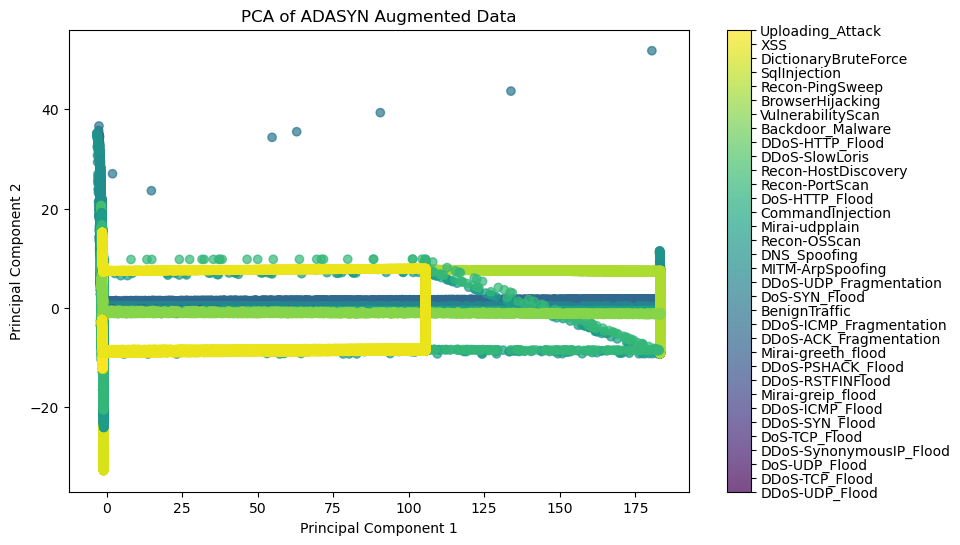


PCA Analysis for CVAE augmented data
Explained Variance Ratio: [0.24631002 0.12349919]
PCA Loadings (transposed):
                      PC1       PC2
flow_duration    0.019869  0.054180
Header_Length    0.101348  0.076541
Protocol Type   -0.002721  0.098963
Duration         0.267423  0.037751
Rate            -0.015579 -0.030377
Srate           -0.017853 -0.031346
Drate           -0.001157 -0.007062
fin_flag_number -0.047444  0.039738
syn_flag_number -0.046502  0.036301
rst_flag_number -0.042274  0.076575
psh_flag_number -0.018350 -0.092816
ack_flag_number  0.229350 -0.430063
ece_flag_number -0.008518  0.000212
cwr_flag_number -0.001048 -0.006723
ack_count       -0.034997 -0.116557
syn_count        0.124287 -0.381269
fin_count       -0.026502 -0.027936
urg_count        0.113313 -0.012729
rst_count        0.152256  0.040067
HTTP            -0.033091 -0.393860
HTTPS            0.289183  0.062702
DNS             -0.000362  0.009502
Telnet          -0.001169  0.001125
SMTP             0.00

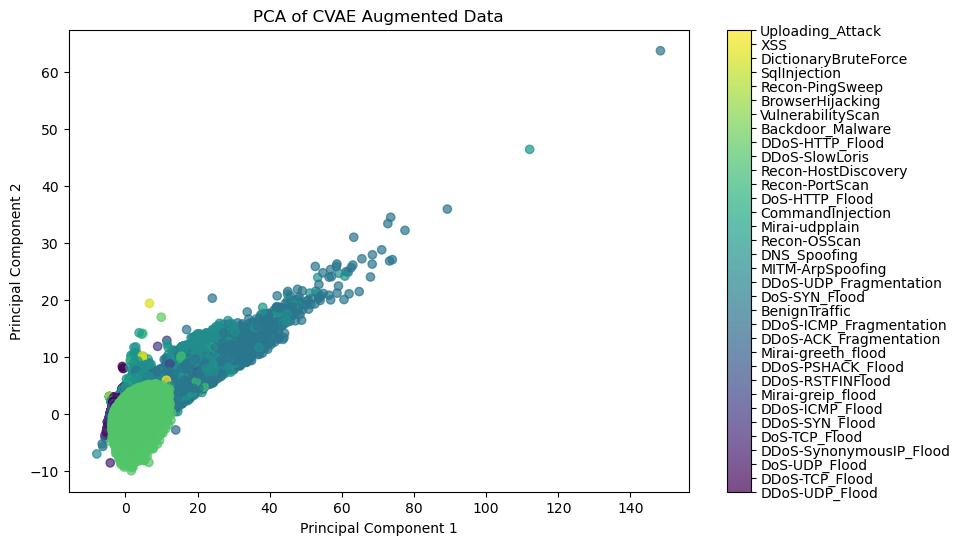


PCA Analysis for GAN augmented data
Explained Variance Ratio: [0.41181    0.30085225]
PCA Loadings (transposed):
                      PC1       PC2
flow_duration   -0.011814  0.064608
Header_Length    0.092880  0.028763
Protocol Type    0.019256 -0.030136
Duration         0.280920  0.182065
Rate            -0.011400  0.027592
Srate            0.001901  0.053426
Drate            0.012162  0.006619
fin_flag_number -0.027394 -0.035547
syn_flag_number  0.060812 -0.084532
rst_flag_number  0.034258 -0.016815
psh_flag_number -0.174726 -0.058473
ack_flag_number -0.056179  0.495295
ece_flag_number -0.025544 -0.011478
cwr_flag_number -0.030815 -0.015242
ack_count        0.026487 -0.079470
syn_count        0.089119  0.061778
fin_count        0.054904  0.006185
urg_count        0.064294  0.099780
rst_count        0.105551  0.068818
HTTP            -0.562700  0.429431
HTTPS            0.379426 -0.049184
DNS              0.023537  0.009225
Telnet           0.009858  0.006406
SMTP             0.043

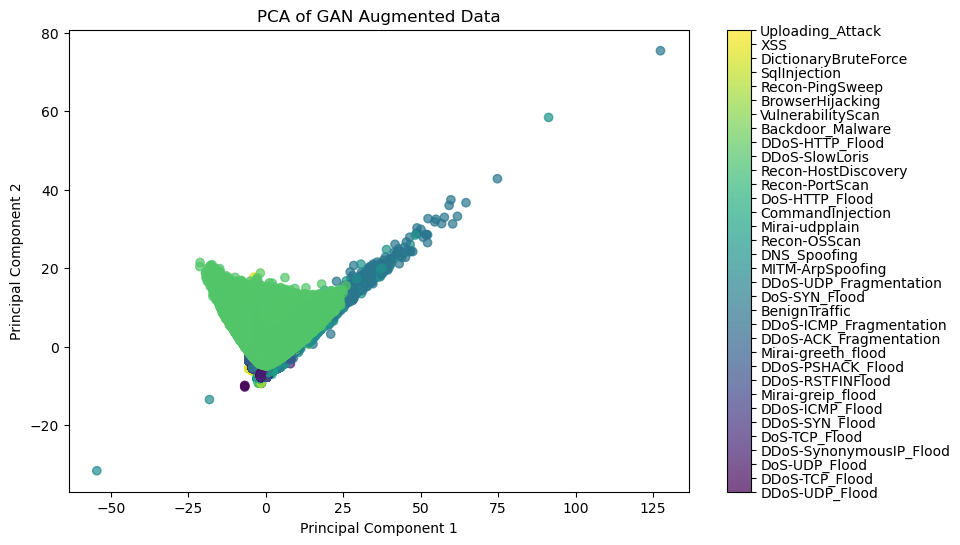

In [11]:
# Perform PCA analysis on each augmented CSV file
files = {
    "SMOTE": "augmented_data_smote_full.csv",
    "ADASYN": "augmented_data_adasyn_full.csv",
    "CVAE": "augmented_data_cvae_full.csv",
    "GAN": "augmented_data_gan_full.csv"
}

for method, file in files.items():
    print(f"\nPCA Analysis for {method} augmented data")
    df_aug = pd.read_csv(file)
    X_aug = df_aug[feature_columns].values
    y_aug = df_aug['label'].values
    
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_aug)
    
    print("Explained Variance Ratio:", pca.explained_variance_ratio_)
    loadings = pd.DataFrame(pca.components_, columns=feature_columns, index=["PC1", "PC2"])
    print("PCA Loadings (transposed):")
    print(loadings.T)
    
    plt.figure(figsize=(10, 6))
    y_factor, uniques = pd.factorize(y_aug)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_factor, cmap='viridis', alpha=0.7)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA of {method} Augmented Data')
    cbar = plt.colorbar(scatter, ticks=range(len(uniques)))
    cbar.ax.set_yticklabels(uniques)
    plt.show()

## t-SNE Analysis on Augmented CSV Data

This section reads the saved CSV files and applies t-SNE on the full feature set (46 features),
using the original multi-class labels for coloring. A random subset of 5000 samples is used if necessary.


t-SNE Analysis for SMOTE augmented data


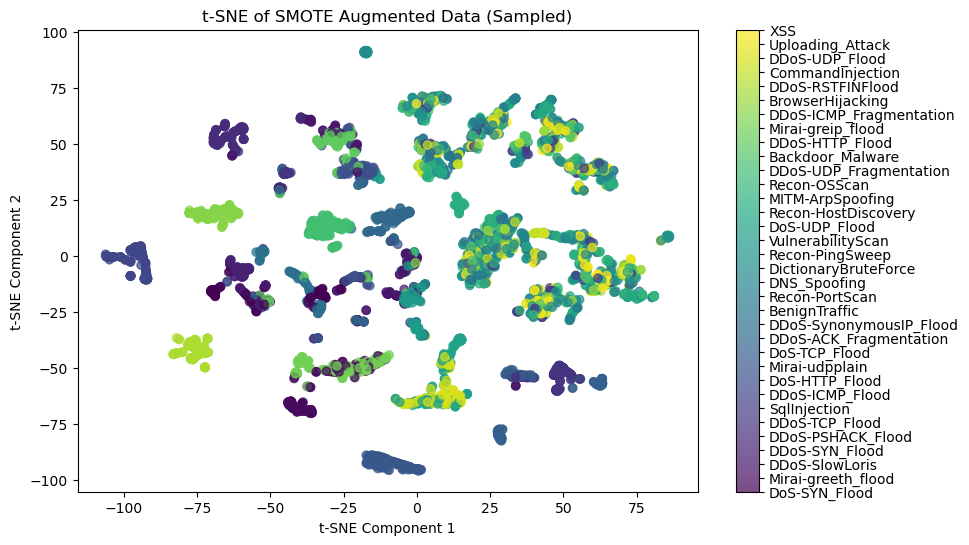


t-SNE Analysis for ADASYN augmented data


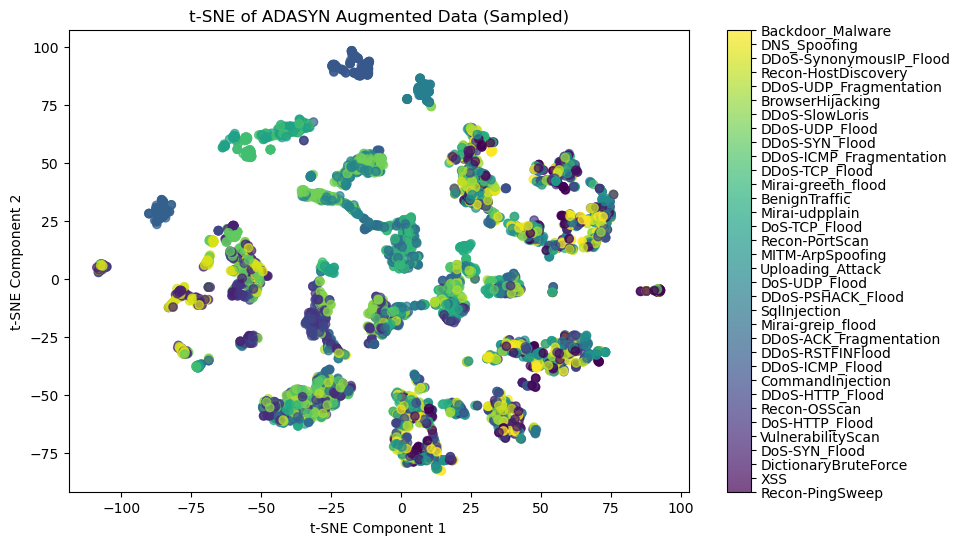


t-SNE Analysis for CVAE augmented data


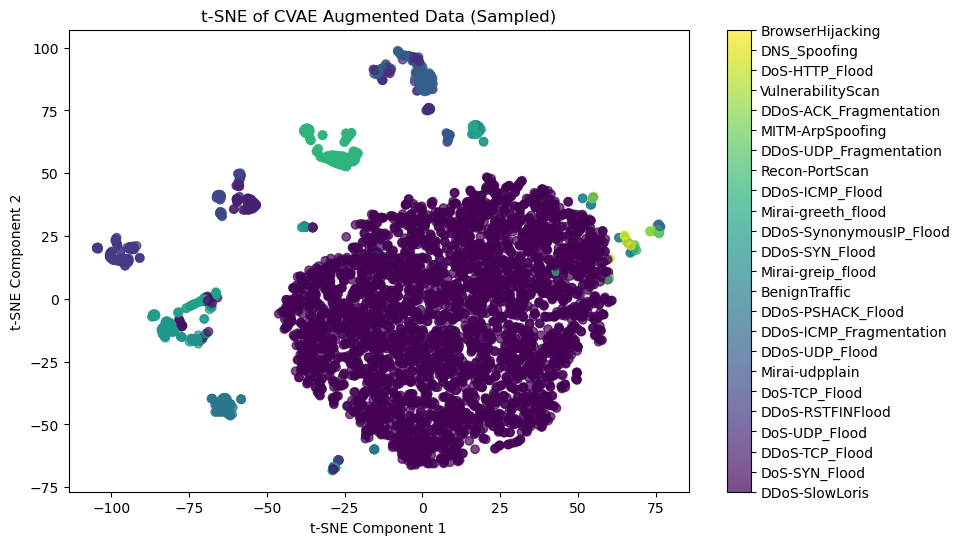


t-SNE Analysis for GAN augmented data


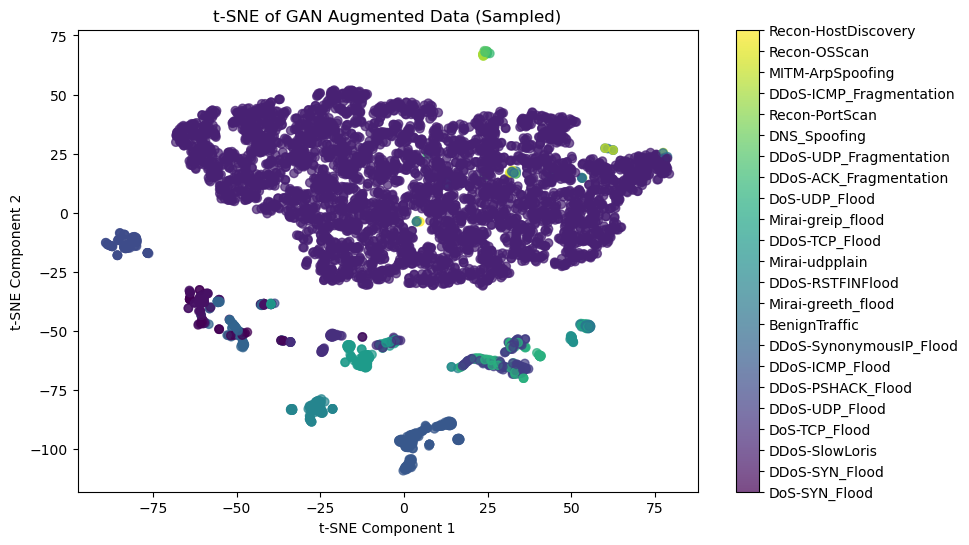

In [12]:
# Perform t-SNE analysis on each augmented CSV file
for method, file in files.items():
    print(f"\nt-SNE Analysis for {method} augmented data")
    df_aug = pd.read_csv(file)
    X_aug = df_aug[feature_columns].values
    y_aug = df_aug['label'].values
    
    sample_size = 5000
    if X_aug.shape[0] > sample_size:
        idx = np.random.choice(X_aug.shape[0], sample_size, replace=False)
        X_tsne = X_aug[idx]
        y_tsne = y_aug[idx]
    else:
        X_tsne = X_aug
        y_tsne = y_aug
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=2000)
    X_tsne_transformed = tsne.fit_transform(X_tsne)
    
    plt.figure(figsize=(10, 6))
    y_factor, uniques = pd.factorize(y_tsne)
    scatter = plt.scatter(X_tsne_transformed[:, 0], X_tsne_transformed[:, 1], c=y_factor, cmap='viridis', alpha=0.7)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE of {method} Augmented Data (Sampled)')
    cbar = plt.colorbar(scatter, ticks=range(len(uniques)))
    cbar.ax.set_yticklabels(uniques)
    plt.show()